# Identitas Diri
Nama : Indiarto Aji Begawan \
Email : indiartoaji13@gmail.com \
Learning Path : Belajar Pengembangan Machine Learning \
Materi : Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series \


# Library

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Stock Prediction

In [72]:
df = pd.read_csv('IBM.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,1.652504,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,1.666948,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,1.650337,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,1.617836,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,1.587500,572685
...,...,...,...,...,...,...,...
15278,2022-09-12,130.330002,130.990005,129.889999,130.660004,130.660004,3741100
15279,2022-09-13,129.139999,129.910004,126.769997,127.250000,127.250000,4565600
15280,2022-09-14,127.500000,129.000000,126.849998,127.690002,127.690002,3819100
15281,2022-09-15,127.389999,127.470001,124.900002,125.489998,125.489998,5141700


Dataset iambil dari yahoo finance dengan nama saham IBM (https://finance.yahoo.com/quote/IBM/history?period1=-252374400&period2=1663459200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15283 entries, 0 to 15282
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15283 non-null  object 
 1   Open       15283 non-null  float64
 2   High       15283 non-null  float64
 3   Low        15283 non-null  float64
 4   Close      15283 non-null  float64
 5   Adj Close  15283 non-null  float64
 6   Volume     15283 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 835.9+ KB


In [74]:
threshold_mae = (df['Adj Close'].max() - df['Adj Close'].min()) * 10/100
threshold_mae

14.0990372

Block diatas bertujuan untuk melihat threshold dari MAE untuk dapat mengkalkulasi persyaratan yang diberikan

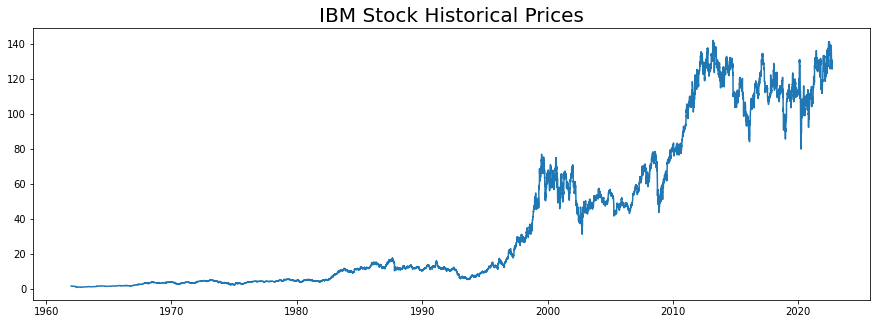

In [88]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
dates      = df['Date'].values
close      = df['Adj Close'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates,close)
plt.title('IBM Stock Historical Prices',
          fontsize=20);

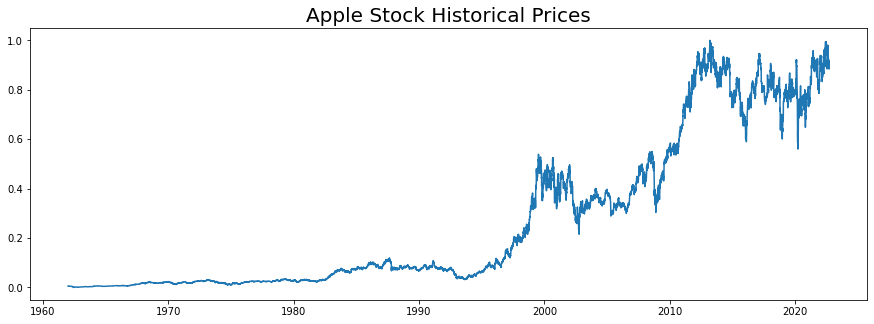

In [77]:
scaler = MinMaxScaler()

close = np.reshape(close,(-1,1))
close = scaler.fit_transform(close)

plt.figure(figsize=(15,5))
plt.plot(dates,close)
plt.title('Apple Stock Historical Prices',
          fontsize=20);

close = np.reshape(close,(-1))

Block diatas bertujuan untuk menampilkan data saham dari kolom Adj Close (harga penutupan saham pada hari tersebut) yang telah di di scaling dalam rentang nilai 0-1.

In [78]:
x_train, x_test, y_train, y_test = train_test_split(close, dates, test_size=0.2, shuffle=False)

In [79]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

Block diatas bertujuan untuk membuat data training dan testing dari dataset saham yang dipilih.

In [82]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Model yang dibuat mengikuti materi yang diberikan pada Dicoding.

In [84]:
history = model.fit(train_set,epochs=10, validation_data=test_set, verbose=2)

Epoch 1/10
122/122 - 19s - loss: 0.0160 - mae: 0.1137 - val_loss: 0.2477 - val_mae: 0.6998 - 19s/epoch - 152ms/step
Epoch 2/10
122/122 - 14s - loss: 0.0126 - mae: 0.0977 - val_loss: 0.2229 - val_mae: 0.6635 - 14s/epoch - 118ms/step
Epoch 3/10
122/122 - 15s - loss: 0.0110 - mae: 0.0981 - val_loss: 0.2059 - val_mae: 0.6375 - 15s/epoch - 120ms/step
Epoch 4/10
122/122 - 15s - loss: 0.0103 - mae: 0.1026 - val_loss: 0.1940 - val_mae: 0.6185 - 15s/epoch - 119ms/step
Epoch 5/10
122/122 - 14s - loss: 0.0099 - mae: 0.1064 - val_loss: 0.1852 - val_mae: 0.6042 - 14s/epoch - 118ms/step
Epoch 6/10
122/122 - 14s - loss: 0.0096 - mae: 0.1088 - val_loss: 0.1785 - val_mae: 0.5930 - 14s/epoch - 118ms/step
Epoch 7/10
122/122 - 15s - loss: 0.0095 - mae: 0.1103 - val_loss: 0.1733 - val_mae: 0.5842 - 15s/epoch - 120ms/step
Epoch 8/10
122/122 - 15s - loss: 0.0093 - mae: 0.1111 - val_loss: 0.1691 - val_mae: 0.5770 - 15s/epoch - 123ms/step
Epoch 9/10
122/122 - 14s - loss: 0.0092 - mae: 0.1114 - val_loss: 0.1655

Terdapat perbedaan yang mencolok jika dataset menggunakan MinMaxScaler dan yang tidak menggunakan. Dataset yang menggunakan MinMixScaler cenderung memiliki selisih nilai MAE dan Validation MAE yang sangat kecil, berbanding terbalik jika tidak menggunakan MinMixScaler yang memiliki nilai selisih sampai 60 point. Hal tersebutlah yang menjadi alasan mengapa dalam script ini menggunakan MinMaxScaler.

In [67]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


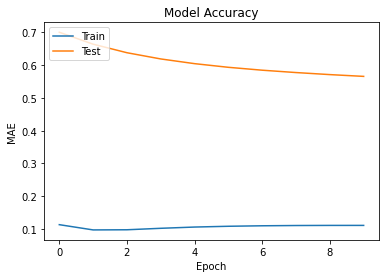

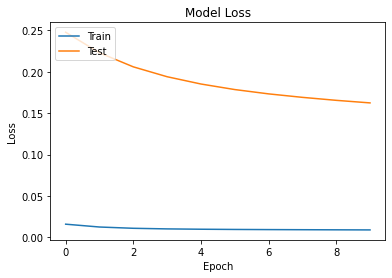

In [86]:
# Grafik Accuracy dan Validation Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Grafik Accuracy dan Validation Accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Nilai MAE dan Loss pada train dan test cenderung memiliki grafik yang sama. 